In [2]:
import configparser
import time
import math

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.linear_model

from solml import cnn, load
from solml.train import split, get_info

In [3]:
config = configparser.ConfigParser()
config.read('../config.ini')
roof_cache_dir = config['main']['roof_cache_dir']

## Size of images

In [4]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.two_balanced_classes()
idents = train_ids + val_ids + test_ids
bounding_boxes = get_info.get_bounding_box(idents)
images = load.load_data(idents, bounding_boxes, 5, 5, False) # download

In [5]:
N = len(idents)
print("%d images"%N)
sizes = np.zeros((N, 2))
for i, ident in enumerate(idents):
    filename = roof_cache_dir + str(ident) + '.jpg'
    image = Image.open(filename)
    x, y = image.size
    sizes[i, 0] = x
    sizes[i, 1] = y

6000 images


array([ 87.58633333,  88.56233333])

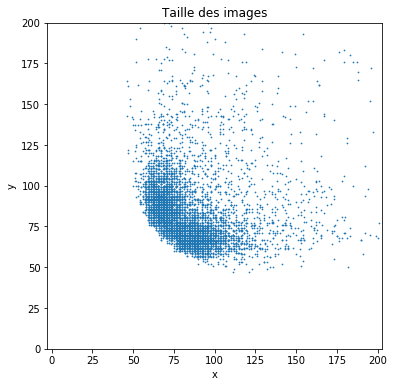

In [6]:
# plot sizes of images
plt.figure(figsize=(6, 6))
plt.scatter(sizes[:, 0], sizes[:, 1], s=0.5)
plt.axis('equal')
plt.xlim([0,200])
plt.ylim([0,200])
plt.title('Taille des images')
plt.xlabel('x')
plt.ylabel('y')
sizes.mean(axis=0)

## Use the CNN features to train a classifier

In [7]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.two_balanced_classes()

In [8]:
bounding_boxes = get_info.get_bounding_box(train_ids)
cnn_train = cnn.get_cnn_features_list(train_ids, bounding_boxes)

In [9]:
bounding_boxes = get_info.get_bounding_box(val_ids)
cnn_val = cnn.get_cnn_features_list(val_ids, bounding_boxes)

In [10]:
bounding_boxes = get_info.get_bounding_box(test_ids)
cnn_test = cnn.get_cnn_features_list(test_ids, bounding_boxes)

In [15]:
n_C = 15
C_list = np.logspace(-10, 2, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.111222 seconds.
LR took 0.111134 seconds.
LR took 0.128497 seconds.
LR took 0.174408 seconds.
LR took 0.198488 seconds.
LR took 0.295850 seconds.
LR took 0.549194 seconds.
LR took 0.851691 seconds.
LR took 1.352875 seconds.
LR took 1.944742 seconds.
LR took 2.353184 seconds.
LR took 2.147620 seconds.
LR took 1.974275 seconds.
LR took 2.056191 seconds.
LR took 2.328148 seconds.


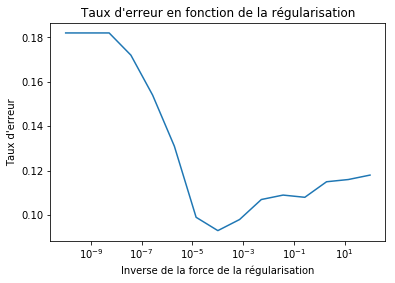

In [16]:
plt.plot(C_list, errors)
plt.title("Taux d'erreur en fonction de la régularisation")
plt.ylabel("Taux d'erreur")
plt.xlabel("Inverse de la force de la régularisation")
plt.xscale('log')

In [17]:
i_opt = np.argmin(errors)
C_opt = C_list[i_opt] #0.000018#
print('optimal C : %f'%C_opt)
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt)
t = time.time()
model.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000100
LR took 0.859890 seconds.


In [18]:
err

0.087999999999999995

In [19]:
cnn_proba_val = model.predict_proba(cnn_val)[:,0]
cnn_proba_test = model.predict_proba(cnn_test)[:,0]

## Visualize some wrong predictions

In [20]:
indexes_wrong = np.where(test_labels!=predictions)[0]

In [21]:
indexes_wrong = np.where(test_labels!=predictions)[0]
def show_wrong():
    i = np.random.choice(indexes_wrong)
    ident = test_ids[i]

    image = np.array(Image.open(roof_cache_dir + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

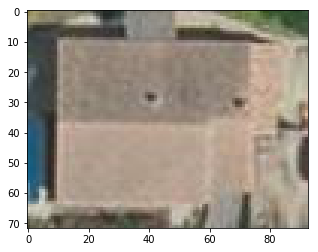

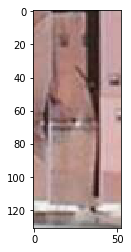

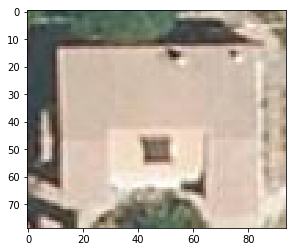

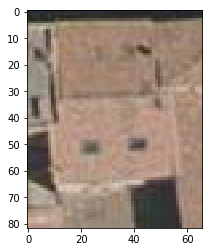

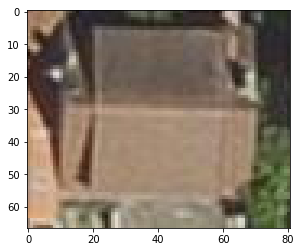

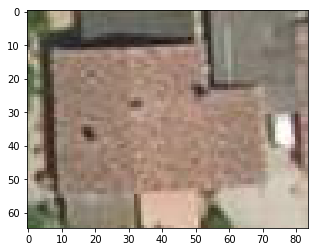

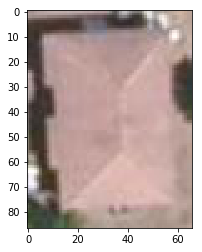

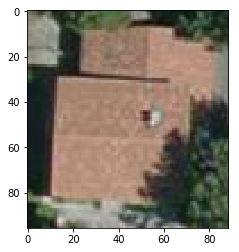

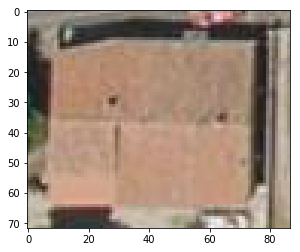

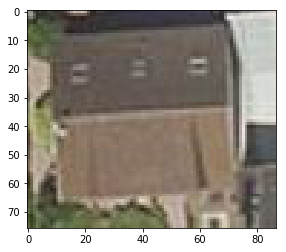

In [22]:
for i in range(10):
    show_wrong()

In [23]:
indexes_right = np.where(test_labels==predictions)[0]
def show_right():
    i = np.random.choice(indexes_right)
    ident = test_ids[i]

    image = np.array(Image.open(roof_cache_dir + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

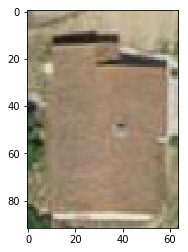

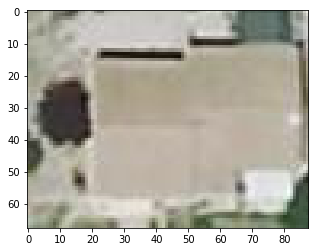

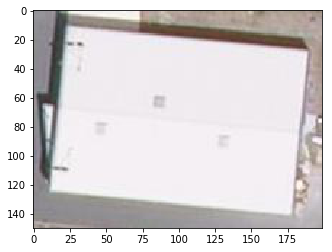

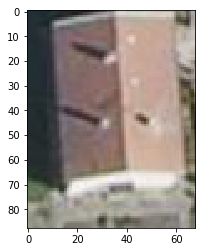

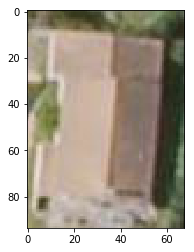

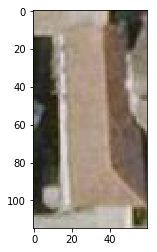

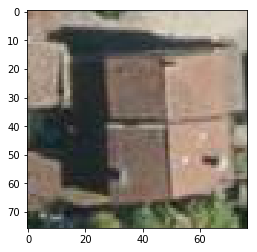

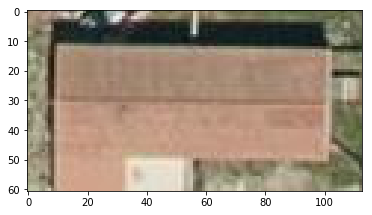

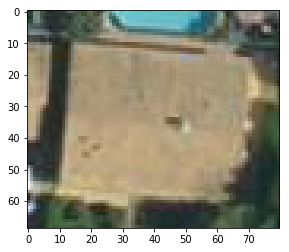

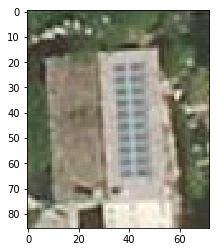

In [24]:
for i in range(10):
    show_right()

# Mix with other features

In [25]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = split.load_images(train_ids, val_ids, test_ids, l, color)

In [26]:
train_reduc = train_reduc.reshape((4000, l*l))
val_reduc = val_reduc.reshape((1000, l*l))
test_reduc = test_reduc.reshape((1000, l*l))

In [27]:
train_ids[0]

'154812325'

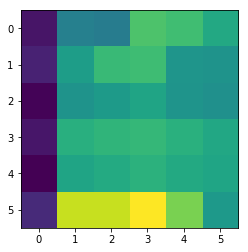

In [28]:
plt.imshow(train_reduc[0].reshape(6, 6), interpolation='none')

In [29]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(train_reduc, train_labels)
predictions = model.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.20000000000000001

In [30]:
reduc_proba_val = model.predict_proba(val_reduc)[:,0]
reduc_proba_test = model.predict_proba(test_reduc)[:,0]

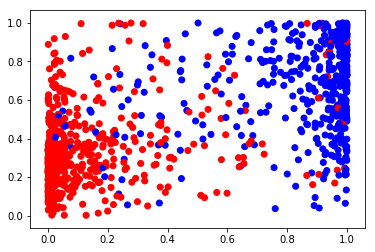

In [31]:
def colorize(labels):
    return ['b' if l==1 else 'r' for l in labels]
plt.scatter(cnn_proba_val, reduc_proba_val, c=colorize(val_labels))

In [32]:
N_val = len(reduc_proba_val)
val_mix = np.zeros((N_val, 2))
val_mix[:, 0] = cnn_proba_val
val_mix[:, 1] = reduc_proba_val
N_test = len(reduc_proba_test)
test_mix = np.zeros((N_test, 2))
test_mix[:, 0] = cnn_proba_test
test_mix[:, 1] = reduc_proba_test

In [33]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(val_mix, val_labels)
predictions = model.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.088999999999999996

In [34]:
probas = model.predict_proba(test_mix)

## Confidence

In [35]:
confidence = np.max(probas, axis=1)

(array([   4.,    0.,    3.,    2.,    3.,    1.,    0.,    0.,    3.,
           4.,    2.,    1.,    3.,    4.,    1.,    4.,    4.,    0.,
           1.,    1.,    0.,    3.,    4.,    1.,    2.,    2.,    2.,
           2.,    1.,    1.,    2.,    3.,    2.,    0.,    1.,    0.,
           2.,    1.,    1.,    1.,    2.,    3.,    1.,    2.,    3.,
           0.,    0.,    0.,    0.,    2.,    1.,    4.,    4.,    2.,
           2.,    2.,    1.,    3.,    1.,    2.,    2.,    2.,    3.,
           5.,    1.,    1.,    6.,    5.,    4.,    3.,    2.,    3.,
           4.,    8.,    3.,   11.,    4.,    8.,    5.,    7.,    8.,
          14.,    5.,   11.,    8.,   11.,   16.,   19.,   18.,   27.,
          18.,   27.,   26.,   42.,   58.,   73.,  112.,  104.,  112.,   97.]),
 array([ 0.50066237,  0.5055572 ,  0.51045204,  0.51534688,  0.52024171,
         0.52513655,  0.53003139,  0.53492622,  0.53982106,  0.5447159 ,
         0.54961073,  0.55450557,  0.55940041,  0.56429524,  0.5

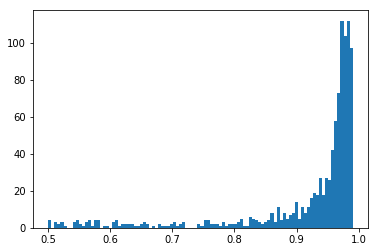

In [36]:
plt.hist(confidence, bins=100)

In [37]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N_test)

/home/salon/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


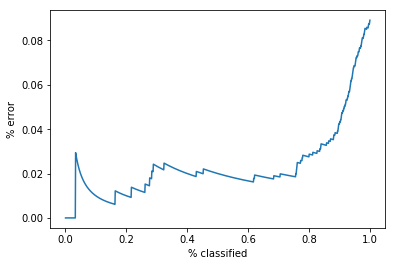

In [38]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [39]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

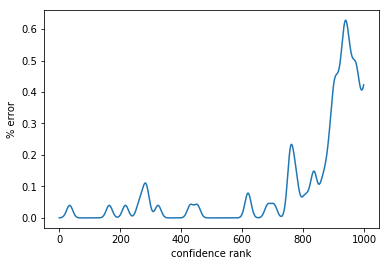

In [40]:
sigma = 10.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')